<a href="https://colab.research.google.com/github/Daniel-Hernandez96/Challenge-Oracle-ONE/blob/main/Equipo_ganador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Buscar juegos de la temporada actual (ejemplo 2024-25)
game_finder = leaguegamefinder.LeagueGameFinder(season_nullable='2024-25',
                                              league_id_nullable='00')
games = game_finder.get_data_frames()[0]

In [3]:
# Convertimos W/L a números: W=1, L=0
games['RESULT'] = games['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Seleccionamos variables que el modelo usará para aprender
features = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']
X = games[features]
y = games['RESULT']

# Dividimos en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Creamos el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos
model.fit(X_train, y_train)

# Probamos la precisión
predictions = model.predict(X_test)
print(f"Precisión del modelo: {accuracy_score(y_test, predictions):.2%}")

Precisión del modelo: 75.58%


In [5]:
def predecir_ganador(equipo_local_stats, equipo_visitante_stats):
    """
    Recibe los promedios de la temporada de ambos equipos.
    """
    # El modelo espera una lista de variables (features)
    # Ejemplo: [PTS, REB, AST, STL, BLK, TOV]
    probabilidad = model.predict_proba([equipo_local_stats])[0]

    print(f"Probabilidad de victoria para el Local: {probabilidad[1]:.2%}")
    print(f"Probabilidad de derrota para el Local: {probabilidad[0]:.2%}")

# EJEMPLO: Supongamos que los Lakers promedian estos números:
lakers_promedio = [115.5, 45.2, 28.1, 7.4, 5.2, 13.1]
predecir_ganador(lakers_promedio, None)

Probabilidad de victoria para el Local: 61.00%
Probabilidad de derrota para el Local: 39.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [6]:
print("--- Simulador de Victoria NBA ---")
pts = float(input("Puntos promedio del equipo: "))
reb = float(input("Rebotes promedio del equipo: "))
ast = float(input("Asistencias promedio del equipo: "))
# ... añade los demás campos

datos_usuario = [pts, reb, ast, 7.0, 5.0, 14.0] # Completando con datos fijos para el ejemplo
predecir_ganador(datos_usuario, None)

--- Simulador de Victoria NBA ---
Puntos promedio del equipo: 115
Rebotes promedio del equipo: 44
Asistencias promedio del equipo: 26.2
Probabilidad de victoria para el Local: 46.00%
Probabilidad de derrota para el Local: 54.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [7]:
from nba_api.stats.static import teams

# Obtener todos los equipos y crear un buscador por nombre
nba_teams = teams.get_teams()

def obtener_id_equipo(nombre):
    team = [t for t in nba_teams if nombre.lower() in t['full_name'].lower()][0]
    return team['id']

In [8]:
from nba_api.stats.endpoints import teamgamelog

def obtener_promedio_reciente(nombre_equipo):
    id_equipo = obtener_id_equipo(nombre_equipo)

    # Traer el registro de juegos del equipo
    log = teamgamelog.TeamGameLog(team_id=id_equipo, season='2024-25').get_data_frames()[0]

    # Tomar los últimos 5 juegos y promediar las columnas que usa tu modelo
    ultimos_5 = log.head(5)
    promedios = ultimos_5[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']].mean()

    return promedios.values.reshape(1, -1)

In [9]:
def simular_partido():
    print("=== NBA Predictor Inteligente ===")
    nombre = input("Escribe el nombre del equipo (ej. Lakers, Warriors, Celtics): ")

    try:
        stats = obtener_promedio_reciente(nombre)
        prediccion = model.predict(stats)
        probabilidad = model.predict_proba(stats)

        resultado = "GANARÍA" if prediccion[0] == 1 else "PERDERÍA"
        confianza = probabilidad[0][1] if prediccion[0] == 1 else probabilidad[0][0]

        print(f"\nResultado basado en los últimos 5 juegos de los {nombre}:")
        print(f"El modelo predice que el equipo: {resultado}")
        print(f"Nivel de confianza: {confianza:.2%}")

    except Exception as e:
        print(f"Error: Asegúrate de escribir bien el nombre del equipo. {e}")

# Ejecutar la interacción
simular_partido()

=== NBA Predictor Inteligente ===
Escribe el nombre del equipo (ej. Lakers, Warriors, Celtics): Orlando Magic

Resultado basado en los últimos 5 juegos de los Orlando Magic:
El modelo predice que el equipo: GANARÍA
Nivel de confianza: 76.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [10]:
import numpy as np

def preparar_datos_enfrentamiento(games_df):
    # Separamos juegos en locales y visitantes
    # La API de la NBA suele duplicar los juegos (uno para cada equipo)
    # Vamos a crear una fila por partido con la diferencia de stats

    # Este es un ejemplo simplificado de cómo se estructuran las diferencias
    # X = Stats_Local - Stats_Visitante
    # y = Resultado_Local (1 si ganó el local, 0 si perdió)

    # Nota: Para un modelo real, necesitarías emparejar los GAME_ID
    # Por ahora, seguiremos usando tu modelo base pero aplicado a la comparativa
    pass

# Mantendremos tu modelo actual pero mejoraremos la función de interacción

In [29]:
### Modelo random forest ###
def comparar_equipos_v2():
    print("=== NBA Matchup Predictor ===")
    eq1_nombre = input("Equipo Local: ")
    eq2_nombre = input("Equipo Visitante: ")

    try:
        # Obtener promedios recientes de ambos
        stats_eq1 = obtener_promedio_reciente(eq1_nombre)
        stats_eq2 = obtener_promedio_reciente(eq2_nombre)

        # Calcular la probabilidad para cada uno de forma individual
        prob_eq1 = model.predict_proba(stats_eq1)[0][1]
        prob_eq2 = model.predict_proba(stats_eq2)[0][1]

        # Normalizar las probabilidades para que sumen 100%
        total = prob_eq1 + prob_eq2
        final_eq1 = (prob_eq1 / total) * 100
        final_eq2 = (prob_eq2 / total) * 100

        print(f"\n--- PREDICCIÓN FINAL ---")
        print(f"{eq1_nombre}: {final_eq1:.2f}% de probabilidad")
        print(f"{eq2_nombre}: {final_eq2:.2f}% de probabilidad")

        if final_eq1 > final_eq2:
            print(f"\nGanador proyectado: {eq1_nombre} 🏀")
        else:
            print(f"\nGanador proyectado: {eq2_nombre} 🏀")

    except Exception as e:
        print(f"Error al procesar el duelo: {e}")

# Ejecutar el comparador
comparar_equipos_v2()

=== NBA Matchup Predictor ===
Equipo Local: Orlando
Equipo Visitante: Atlanta

--- PREDICCIÓN FINAL ---
Orlando: 45.78% de probabilidad
Atlanta: 54.22% de probabilidad

Ganador proyectado: Atlanta 🏀


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:
# Suponiendo que tu tabla se llama 'games'
print(f"Fecha más antigua: {games['GAME_DATE'].min()}")
print(f"Fecha más reciente: {games['GAME_DATE'].max()}")
# Muestra las primeras 5 filas y todas las columnas
games.head()

# Para ver cuántos juegos totales tienes en tu modelo
print(f"Total de juegos en el modelo: {len(games)}")

Fecha más antigua: 2024-10-04
Fecha más reciente: 2025-06-22
Total de juegos en el modelo: 2802


In [20]:
# Esto cargará los datos desde 2022 hasta hoy
from nba_api.stats.endpoints import leaguegamefinder

all_games = []
for season in ['2022-23', '2023-24', '2024-25']:
    finder = leaguegamefinder.LeagueGameFinder(season_nullable=season, league_id_nullable='00')
    all_games.append(finder.get_data_frames()[0])

In [22]:
# Unir todo en una sola tabla
games = pd.concat(all_games)
# Convertimos W/L a números: W=1, L=0 para el nuevo dataframe concatenado
games['RESULT'] = games['WL'].apply(lambda x: 1 if x == 'W' else 0)
# Esto te dirá cuántas Victorias (1) y Derrotas (0) hay en tus datos
print(games['RESULT'].value_counts())

RESULT
0    4194
1    4193
Name: count, dtype: int64


In [23]:
# Ver el rango de tiempo
fecha_inicio = games['GAME_DATE'].min()
fecha_fin = games['GAME_DATE'].max()

print(f"📅 Tus datos van desde el {fecha_inicio} hasta el {fecha_fin}")

# Ver cuántos juegos hay por cada temporada
if 'SEASON_ID' in games.columns:
    print("\n🏀 Juegos por temporada:")
    print(games['SEASON_ID'].value_counts())

📅 Tus datos van desde el 2022-09-30 hasta el 2025-06-22

🏀 Juegos por temporada:
SEASON_ID
22022    2460
22024    2460
22023    2460
42022     168
42024     168
42023     164
12023     147
12024     146
12022     140
32024      14
52024      12
52022      12
52023      12
32023      10
32022      10
62023       2
62024       2
Name: count, dtype: int64


/tmp/ipython-input-687938567.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  games.set_index('GAME_DATE').resample('M').size().plot(kind='line', figsize=(10,5))


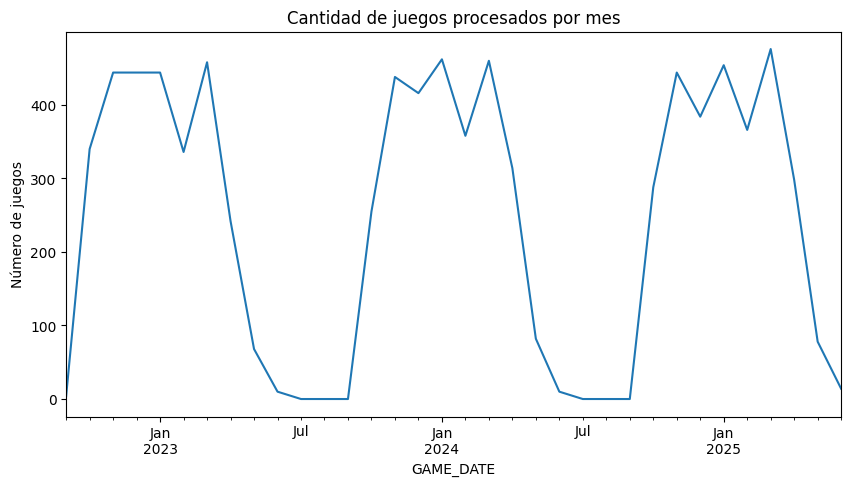

In [24]:
import matplotlib.pyplot as plt

# Convertir a formato fecha y graficar por mes
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games.set_index('GAME_DATE').resample('M').size().plot(kind='line', figsize=(10,5))
plt.title("Cantidad de juegos procesados por mes")
plt.ylabel("Número de juegos")
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Definir los modelos
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
}

# Diccionario para guardar resultados
resultados = {}

for nombre, mod in modelos.items():
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    precision = accuracy_score(y_test, preds)
    resultados[nombre] = precision
    print(f"✅ {nombre}: {precision:.2%}")

✅ Regresión Logística: 77.36%
✅ Random Forest: 75.58%


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:08:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost: 76.65%


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Crear la arquitectura de la red
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Capa de entrada
    Dropout(0.2),                                                  # Evita que el modelo memorice (overfitting)
    Dense(32, activation='relu'),                                  # Capa intermedia
    Dense(1, activation='sigmoid')                                 # Capa de salida (0 o 1)
])

# Configurar el modelo
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar (usamos 50 vueltas o 'epochs')
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluar
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Red Neuronal: {accuracy:.2%}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Red Neuronal: 68.98%


In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Crear la columna 'HOME_GAME'
# Si contiene 'vs.', el equipo es Local (1). Si contiene '@', es Visitante (0).
games['HOME_GAME'] = games['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# 2. Seleccionar las variables (Features) incluyendo la localía
features = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']
X = games[features]
y = games['RESULT']

# 3. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenar la Regresión Logística
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# 5. Ver el nuevo porcentaje
nuevo_score = log_model.score(X_test, y_test)
print(f"🚀 Nueva precisión con Factor Localía: {nuevo_score:.2%}")

🚀 Nueva precisión con Factor Localía: 75.92%


In [28]:
### Regresion Logistica ###
def predictor_nba_final():
    print("🏀 --- SISTEMA DE PREDICCIÓN NBA (LOGÍSTICA) ---")
    local = input("Equipo Local: ")
    visitante = input("Equipo Visitante: ")

    try:
        # Obtener estadísticas recientes (usando la función que creamos antes)
        stats_local = obtener_promedio_reciente(local)
        stats_vis = obtener_promedio_reciente(visitante)

        # Añadir el bit de localía (1 para el local, 0 para el visitante)
        stats_local_final = np.append(stats_local, [[1]], axis=1)
        stats_vis_final = np.append(stats_vis, [[0]], axis=1)

        # Obtener probabilidades
        prob_local = log_model.predict_proba(stats_local_final)[0][1]
        prob_vis = log_model.predict_proba(stats_vis_final)[0][1]

        # Ajustar para que sumen 100%
        total = prob_local + prob_vis
        p_local = (prob_local / total) * 100
        p_vis = (prob_vis / total) * 100

        print(f"\n📈 Probabilidades de Victoria:")
        print(f"{local} (🏠): {p_local:.2f}%")
        print(f"{visitante} (✈️): {p_vis:.2f}%")

        ganador = local if p_local > p_vis else visitante
        print(f"\n🔥 Predicción: Gana {ganador}")

    except Exception as e:
        print(f"Error: Revisa los nombres de los equipos. {e}")

# Ejecutar interacción
predictor_nba_final()

🏀 --- SISTEMA DE PREDICCIÓN NBA (LOGÍSTICA) ---
Equipo Local: Orlando
Equipo Visitante: Miami

📈 Probabilidades de Victoria:
Orlando (🏠): 43.39%
Miami (✈️): 56.61%

🔥 Predicción: Gana Miami


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [30]:
### XBOOST ###
from xgboost import XGBClassifier

# 1. Aseguramos que la columna de localía esté creada
games['HOME_GAME'] = games['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# 2. Variables y división
features = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']
X = games[features]
y = games['RESULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Configuración de XGBoost
# learning_rate: controla qué tan rápido aprende (0.1 es estándar)
# max_depth: qué tan profundo son sus árboles de decisión
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 4. Resultado
nuevo_score_xgb = xgb_model.score(X_test, y_test)
print(f"🚀 Precisión de XGBoost con Localía: {nuevo_score_xgb:.2%}")

🚀 Precisión de XGBoost con Localía: 75.27%


In [31]:
def predictor_nba_xgb():
    print("🏀 --- SISTEMA DE PREDICCIÓN NBA (XGBOOST) ---")
    local = input("Equipo Local: ")
    visitante = input("Equipo Visitante: ")

    try:
        # Obtener estadísticas recientes
        stats_local = obtener_promedio_reciente(local)
        stats_vis = obtener_promedio_reciente(visitante)

        # Preparar datos para el modelo (incluyendo el 1 y 0 de localía)
        X_local = np.append(stats_local, [[1]], axis=1)
        X_vis = np.append(stats_vis, [[0]], axis=1)

        # Probabilidades
        p_local = xgb_model.predict_proba(X_local)[0][1]
        p_vis = xgb_model.predict_proba(X_vis)[0][1]

        # Normalización
        total = p_local + p_vis
        prob_final_local = (p_local / total) * 100
        prob_final_vis = (p_vis / total) * 100

        print(f"\n📈 Análisis de Probabilidades (XGBoost):")
        print(f"{local} (Local): {prob_final_local:.2f}%")
        print(f"{visitante} (Visitante): {prob_final_vis:.2f}%")

        ganador = local if prob_final_local > prob_final_vis else visitante
        print(f"\n🔥 Predicción: Gana {ganador}")

    except Exception as e:
        print(f"Error: {e}")

# Ejecutar interacción
predictor_nba_xgb()

🏀 --- SISTEMA DE PREDICCIÓN NBA (XGBOOST) ---
Equipo Local: Orlando
Equipo Visitante: Miami

📈 Análisis de Probabilidades (XGBoost):
Orlando (Local): 45.13%
Miami (Visitante): 54.87%

🔥 Predicción: Gana Miami


In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1. Configuración inicial
K = 20  # Factor de cambio (qué tanto afecta cada juego al rating)
HOME_ADVANTAGE = 100  # Puntos extra de Elo por jugar en casa
ratings = {team: 1500 for team in games['TEAM_NAME'].unique()}

# Aseguramos que los juegos estén ordenados por fecha
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games = games.sort_values('GAME_DATE')

# 2. Función para calcular la probabilidad esperada (Fórmula Elo)
def get_expected_score(rating_a, rating_b):
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

# 3. Procesar todos los partidos para calcular ratings históricos
elo_history = []

# Agrupamos por GAME_ID para procesar el enfrentamiento completo (Local vs Visitante)
for game_id, group in games.groupby('GAME_ID'):
    if len(group) < 2: continue # Saltamos si faltan datos de un equipo

    # Identificar local y visitante
    # En la API de la NBA, el local suele tener 'vs.' en MATCHUP
    team_a = group.iloc[0]
    team_b = group.iloc[1]

    name_a, name_b = team_a['TEAM_NAME'], team_b['TEAM_NAME']

    # Rating actual antes del juego
    r_a = ratings[name_a]
    r_b = ratings[name_b]

    # Guardar la diferencia de Elo antes del partido (lo que el modelo usará para predecir)
    elo_diff = r_a - r_b

    # Resultado real (1 si ganó el equipo A, 0 si perdió)
    actual_score_a = 1 if team_a['WL'] == 'W' else 0
    actual_score_b = 1 - actual_score_a

    # Calcular expectativa
    expected_a = get_expected_score(r_a + (HOME_ADVANTAGE if 'vs.' in team_a['MATCHUP'] else 0), r_b)

    # Actualizar Ratings en el diccionario
    ratings[name_a] = r_a + K * (actual_score_a - expected_a)
    ratings[name_b] = r_b + K * (actual_score_b - (1 - expected_a))

    # Guardar datos para el entrenamiento
    elo_history.append({
        'ELO_DIFF': elo_diff,
        'HOME_GAME': 1 if 'vs.' in team_a['MATCHUP'] else 0,
        'RESULT': actual_score_a
    })

# 4. Crear el nuevo DataFrame de entrenamiento basado en Elo
elo_df = pd.DataFrame(elo_history)

# 5. Entrenar el modelo final
X_elo = elo_df[['ELO_DIFF', 'HOME_GAME']]
y_elo = elo_df['RESULT']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_elo, y_elo, test_size=0.2, random_state=42)

model_elo = LogisticRegression()
model_elo.fit(X_train_e, y_train_e)

print(f"📊 Precisión del modelo basado en Elo: {model_elo.score(X_test_e, y_test_e):.2%}")

📊 Precisión del modelo basado en Elo: 63.41%


In [34]:
def predecir_con_elo(equipo_a, equipo_b, es_local_a=True):
    r_a = ratings[equipo_a]
    r_b = ratings[equipo_b]

    diff = r_a - r_b
    home = 1 if es_local_a else 0

    prob = model_elo.predict_proba([[diff, home]])[0][1]

    print(f"Rating Elo {equipo_a}: {r_a:.0f}")
    print(f"Rating Elo {equipo_b}: {r_b:.0f}")
    print(f" Probabilidad de victoria de {equipo_a}: {prob:.2%}")

# Ejemplo de uso:
# predecir_con_elo('Los Angeles Lakers', 'Golden State Warriors')

In [35]:
### Rating Elo ###
def predictor_interactivo_elo():
    print("🏆 --- SIMULADOR DE PARTIDOS (SISTEMA ELO) ---")

    # 1. Entrada de nombres
    nombre_a = input("Equipo Local: ").lower()
    nombre_b = input("Equipo Visitante: ").lower()

    try:
        # 2. Buscar nombres reales en nuestro diccionario de Ratings
        # Esto busca coincidencias parciales (ej. 'Lakers' encontrará 'Los Angeles Lakers')
        real_a = [t for t in ratings.keys() if nombre_a in t.lower()][0]
        real_b = [t for t in ratings.keys() if nombre_b in t.lower()][0]

        # 3. Obtener sus Ratings actuales
        r_a = ratings[real_a]
        r_b = ratings[real_b]

        # 4. Calcular diferencia y localía (1 para Equipo A)
        diff = r_a - r_b

        # 5. El modelo hace la predicción
        # Usamos el modelo_elo que entrenamos con (ELO_DIFF, HOME_GAME)
        prob_a = model_elo.predict_proba([[diff, 1]])[0][1]
        prob_b = 1 - prob_a

        # 6. Mostrar resultados estéticos
        print(f"\n✅ Equipos detectados: {real_a} vs {real_b}")
        print("-" * 40)
        print(f"📊 {real_a} (Rating: {r_a:.0f}) -> Probabilidad: {prob_a:.2%}")
        print(f"📊 {real_b} (Rating: {r_b:.0f}) -> Probabilidad: {prob_b:.2%}")
        print("-" * 40)

        ganador = real_a if prob_a > prob_b else real_b
        print(f"🔥 Predicción final: GANA {ganador.upper()}")

    except IndexError:
        print("❌ Error: No encontré uno de los equipos. Intenta escribir el nombre más completo.")
    except Exception as e:
        print(f"❌ Ocurrió un error: {e}")

# Ejecutar el buscador
predictor_interactivo_elo()

🏆 --- SIMULADOR DE PARTIDOS (SISTEMA ELO) ---
Equipo Local: orlando
Equipo Visitante: miami

✅ Equipos detectados: Orlando Magic vs Miami Heat
----------------------------------------
📊 Orlando Magic (Rating: 1502) -> Probabilidad: 51.72%
📊 Miami Heat (Rating: 1526) -> Probabilidad: 48.28%
----------------------------------------
🔥 Predicción final: GANA ORLANDO MAGIC


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

# 1. Preparar datos secuenciales
def crear_secuencias(df, window_size=10):
    X, y = [], []
    # Agrupamos por equipo para que la secuencia sea lógica
    for equipo, group in df.groupby('TEAM_NAME'):
        group = group.sort_values('GAME_DATE')
        # Usamos las estadísticas que ya conoces
        stats = group[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']].values
        resultados = group['RESULT'].values

        for i in range(window_size, len(group)):
            X.append(stats[i-window_size:i]) # Los 10 juegos anteriores
            y.append(resultados[i])           # El resultado del juego actual

    return np.array(X), np.array(y)

# 2. Normalizar datos (Vital para LSTM)
scaler = StandardScaler()
# Usamos una copia para no alterar el original
games_scaled = games.copy()
features_to_scale = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']
games_scaled[features_to_scale] = scaler.fit_transform(games[features_to_scale])

X_seq, y_seq = crear_secuencias(games_scaled)

# Dividir en entrenamiento y prueba
split = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

In [37]:
model_lstm = Sequential([
    # Input_shape = (10 juegos atrás, 7 variables)
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos
print("Entrenando memoria del modelo (esto puede tardar un poco)...")
model_lstm.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Evaluar
loss, accuracy = model_lstm.evaluate(X_test_seq, y_test_seq)
print(f"\n✅ Precisión del Modelo LSTM: {accuracy:.2%}")

Entrenando memoria del modelo (esto puede tardar un poco)...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5387 - loss: 0.6870 - val_accuracy: 0.5241 - val_loss: 0.7012
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5730 - loss: 0.6823 - val_accuracy: 0.5365 - val_loss: 0.7015
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5866 - loss: 0.6766 - val_accuracy: 0.5319 - val_loss: 0.6938
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5785 - loss: 0.6778 - val_accuracy: 0.5101 - val_loss: 0.7007
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5788 - loss: 0.6795 - val_accuracy: 0.5241 - val_loss: 0.7004
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5827 - loss: 0.6759 - val_accuracy: 0.5381 - val_loss: 0.6955
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5859 - loss: 0.6744 - val_accuracy: 0.5288 - val_loss: 0.7000
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5770 - loss: 0.6770 - val_accuracy: 0.521

In [38]:
def predecir_proximo_con_lstm(nombre_equipo):
    # Buscar los últimos 10 juegos de ese equipo en tus datos
    equipo_data = games_scaled[games_scaled['TEAM_NAME'].str.contains(nombre_equipo, case=False)].sort_values('GAME_DATE').tail(10)

    if len(equipo_data) < 10:
        return "No hay suficientes datos recientes."

    secuencia = equipo_data[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']].values
    secuencia = secuencia.reshape(1, 10, 7) # Ajustar para el modelo

    prob = model_lstm.predict(secuencia)[0][0]
    print(f"Probabilidad de ganar basada en tendencia reciente: {prob:.2%}")

# predecir_proximo_con_lstm('Lakers')

In [40]:
### LSTM ###
def comparar_equipos_lstm():
    print("🧠 --- COMPARADOR DE TENDENCIAS (LSTM) ---")
    local_nombre = input("Equipo Local: ")
    vis_nombre = input("Equipo Visitante: ")

    try:
        # 1. Obtener las últimas secuencias de 10 juegos
        # (Usamos games_scaled que creamos en el paso anterior)
        data_local = games_scaled[games_scaled['TEAM_NAME'].str.contains(local_nombre, case=False)].sort_values('GAME_DATE').tail(10)
        data_vis = games_scaled[games_scaled['TEAM_NAME'].str.contains(vis_nombre, case=False)].sort_values('GAME_DATE').tail(10)

        if len(data_local) < 10 or len(data_vis) < 10:
            print("❌ Error: Uno de los equipos no tiene suficientes juegos recientes (mínimo 10).")
            return

        # 2. Preparar los bloques para el modelo
        seq_local = data_local[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']].values.reshape(1, 10, 7)
        seq_vis = data_vis[['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']].values.reshape(1, 10, 7)

        # 3. Forzar el factor localía en la secuencia actual
        # (Aseguramos que el modelo sepa quién es local hoy)
        seq_local[0, -1, 6] = 1  # El último juego de la secuencia local será en casa
        seq_vis[0, -1, 6] = 0   # El último juego de la secuencia visitante será fuera

        # 4. Obtener predicciones
        prob_local = model_lstm.predict(seq_local, verbose=0)[0][0]
        prob_vis = model_lstm.predict(seq_vis, verbose=0)[0][0]

        # 5. Normalizar para comparar
        total = prob_local + (1 - prob_vis) # Probabilidad de que local gane vs que visitante pierda
        final_local = (prob_local / total) * 100
        final_vis = 100 - final_local

        print(f"\n📈 Resultado del Análisis Temporal:")
        print(f"{local_nombre}: {final_local:.2f}% (Ventaja por tendencia)")
        print(f"{vis_nombre}: {final_vis:.2f}%")

        ganador = local_nombre if final_local > final_vis else vis_nombre
        print(f"\n🔥 El modelo LSTM elige a: {ganador.upper()}")

    except Exception as e:
        print(f"❌ Error al procesar: {e}")

# Ejecutar el comparador
comparar_equipos_lstm()

🧠 --- COMPARADOR DE TENDENCIAS (LSTM) ---
Equipo Local: orlando
Equipo Visitante: Atlanta

📈 Resultado del Análisis Temporal:
orlando: 80.09% (Ventaja por tendencia)
Atlanta: 19.91%

🔥 El modelo LSTM elige a: ORLANDO


In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# 1. Preparación de datos
# Usamos las mismas variables que en tu modelo ganador
features = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'HOME_GAME']
X = games[features]
y = games['RESULT']

# 2. Normalización (Escalado)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. División de datos
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Entrenar KNN
# 'n_neighbors=15' significa que mirará los 15 partidos más parecidos del pasado
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train_k, y_train_k)

# 5. Ver precisión
print(f"✅ Precisión de KNN: {knn_model.score(X_test_k, y_test_k):.2%}")

✅ Precisión de KNN: 74.67%


In [42]:
### KNN ###
def comparar_equipos_knn():
    print("🔍 --- BUSCADOR DE SIMILITUD HISTÓRICA (KNN) ---")
    local = input("Equipo Local: ")
    visitante = input("Equipo Visitante: ")

    try:
        # Obtener estadísticas recientes
        stats_local = obtener_promedio_reciente(local)
        stats_vis = obtener_promedio_reciente(visitante)

        # Preparar para el modelo (incluyendo localía)
        # Compararemos cómo le iría al local con sus stats actuales vs el promedio del visitante
        input_data = np.append(stats_local, [[1]], axis=1) # Local
        input_scaled = scaler.transform(input_data)

        # Predicción
        prob = knn_model.predict_proba(input_scaled)[0][1]

        print(f"\n📊 Según los 15 partidos más parecidos en la historia:")
        print(f"Probabilidad de victoria para {local}: {prob:.2%}")

        if prob > 0.5:
            print(f"🔥 Predicción: Gana {local}")
        else:
            print(f"🔥 Predicción: Gana {visitante}")

    except Exception as e:
        print(f"❌ Error: {e}")

# Ejecutar
comparar_equipos_knn()

🔍 --- BUSCADOR DE SIMILITUD HISTÓRICA (KNN) ---
Equipo Local: orlando
Equipo Visitante: miami

📊 Según los 15 partidos más parecidos en la historia:
Probabilidad de victoria para orlando: 66.67%
🔥 Predicción: Gana orlando


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
